####
Bangkok Traffic & Mobility Analytics 


In [ ]:
from pathlib import Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
EXP = Path("exports")
EXP.mkdir(exist_ok=True)
DATA = Path("data")


In [18]:
FILES = sorted(glob.glob(str(DATA / '2024060*.csv.out')))
print(f'Found {len(FILES)} files:')
for f in FILES:
    print(' -', Path(f).name)

assert len(FILES) >= 1, "No probe files found."


Found 7 files:
 - 20240601.csv.out
 - 20240602.csv.out
 - 20240603.csv.out
 - 20240604.csv.out
 - 20240605.csv.out
 - 20240606.csv.out
 - 20240607.csv.out


In [19]:

USE_COLS = {
    'vehicle':   0,
    'lat':       2,
    'lon':       3,
    'timestamp': 4,
    'speed':     5,
}

def load_probe_file(path: str) -> pd.DataFrame:
    """Load one .csv.out file and return cleaned rows with date/hour features."""
    df = pd.read_csv(
        path,
        header=None,
        usecols=list(USE_COLS.values()),
        names=list(USE_COLS.keys())
    )

  
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['speed'] = pd.to_numeric(df['speed'], errors='coerce')


    #cleaning
    df = df.dropna(subset=['timestamp', 'lat', 'lon', 'speed'])
    df = df[(df['speed'] >= 0) & (df['speed'] <= 200)]   # sane speeds

    # Features
    df['date'] = df['timestamp'].dt.floor('D')
    df['hour'] = df['timestamp'].dt.hour
    df['weekday'] = df['timestamp'].dt.day_name()
    df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])
    return df[['vehicle','lat','lon','timestamp','speed','date','hour','weekday','is_weekend']]


In [20]:

daily = []
for f in FILES:
    print('Processing', Path(f).name)
    d = load_probe_file(f)
    d['source_file'] = Path(f).name
    daily.append(d)

raw = pd.concat(daily, ignore_index=True)
print('Rows:', len(raw), '| Date range:', raw['date'].min().date(), '→', raw['date'].max().date())
raw.head()


Processing 20240601.csv.out
Processing 20240602.csv.out
Processing 20240603.csv.out
Processing 20240604.csv.out
Processing 20240605.csv.out
Processing 20240606.csv.out
Processing 20240607.csv.out
Rows: 14278012 | Date range: 1970-01-01 → 2024-06-07


,vehicle,lat,lon,timestamp,speed,date,hour,weekday,is_weekend,source_file
0,RfLIL0wm0mFmfKYoU/3JRrFXuNM,13.88489,100.40980,2024-05-31 23:55:55,0,2024-05-31,23,Friday,False,20240601.csv.out
1,rVaYbXEwjNCz1cRd6NXojXTTQwg,14.05004,100.61698,2024-05-31 23:56:25,59,2024-05-31,23,Friday,False,20240601.csv.out
2,kB++j4En9ZH5kkiXrWr7k2p7VaU,13.75116,100.44187,2024-05-31 23:56:25,0,2024-05-31,23,Friday,False,20240601.csv.out
3,KnScXtbvQ0lRj/04+wQ3fO0qtMA,13.87093,100.48262,2024-05-31 23:57:15,98,2024-05-31,23,Friday,False,20240601.csv.out
4,+c1pmA68K6XStwhTtQtt460tskQ,13.74068,100.60030,2024-05-31 23:57:16,53,2024-05-31,23,Friday,False,20240601.csv.out


In [21]:

hourly = (raw
          .groupby(['date','hour'], as_index=False)
          .agg(avg_speed=('speed','mean'),
               points=('speed','count')))


hourly = hourly[(hourly['date'] >= pd.to_datetime('2024-06-01')) &
                (hourly['date'] <= pd.to_datetime('2024-06-07'))]

hourly = hourly.sort_values(['date','hour']).reset_index(drop=True)
hourly.head(), hourly.tail(), hourly.shape


(        date  hour  avg_speed  points
 0 2024-06-01     0   9.747106   74818
 1 2024-06-01     1   9.010986   71362
 2 2024-06-01     2   7.767052   72205
 3 2024-06-01     3   7.602209   72513
 4 2024-06-01     4   9.042137   73427,
           date  hour  avg_speed  points
 163 2024-06-07    19  13.864115   95036
 164 2024-06-07    20  13.991952   90834
 165 2024-06-07    21  13.863609   87924
 166 2024-06-07    22  12.342392   83790
 167 2024-06-07    23  10.594421   78187,
 (168, 4))

In [24]:
# KPI summaries
speed_by_hour  = hourly.groupby('hour')['avg_speed'].mean().round(2)
points_by_hour = hourly.groupby('hour')['points'].sum()

peak_slow_hour = speed_by_hour.idxmin()
peak_fast_hour = speed_by_hour.idxmax()
min_speed      = float(speed_by_hour.loc[peak_slow_hour])
max_speed      = float(speed_by_hour.loc[peak_fast_hour])

busiest_hour   = points_by_hour.idxmax()
busiest_points = int(points_by_hour.max())

# Weekend vs Weekday 
wk_speed = (raw.groupby('is_weekend')['speed'].mean()
              .rename({False:'Weekday', True:'Weekend'})
              .round(2))
wk_points = (raw.groupby('is_weekend').size()
               .rename({False:'Weekday', True:'Weekend'}))

print('Slowest hour  : H=', peak_slow_hour, '| avg speed ≈', min_speed, 'km/h')
print('Fastest hour  : H=', peak_fast_hour, '| avg speed ≈', max_speed, 'km/h')
print('Busiest hour  : H=', busiest_hour,  '| points ≈', f'{busiest_points:,}')
print('Weekend vs Weekday speed (km/h):')
display(wk_speed)
print('Weekend vs Weekday points:')
display(wk_points)


Slowest hour  : H= 3 | avg speed ≈ 6.34 km/h
Fastest hour  : H= 14 | avg speed ≈ 15.38 km/h
Busiest hour  : H= 16 | points ≈ 677,165
Weekend vs Weekday speed (km/h):


is_weekend
Weekday    12.42
Weekend    13.17
Name: speed, dtype: float64

Weekend vs Weekday points:


is_weekend
Weekday    10226306
Weekend     4051706
dtype: int64

Saved charts to /exports ✅


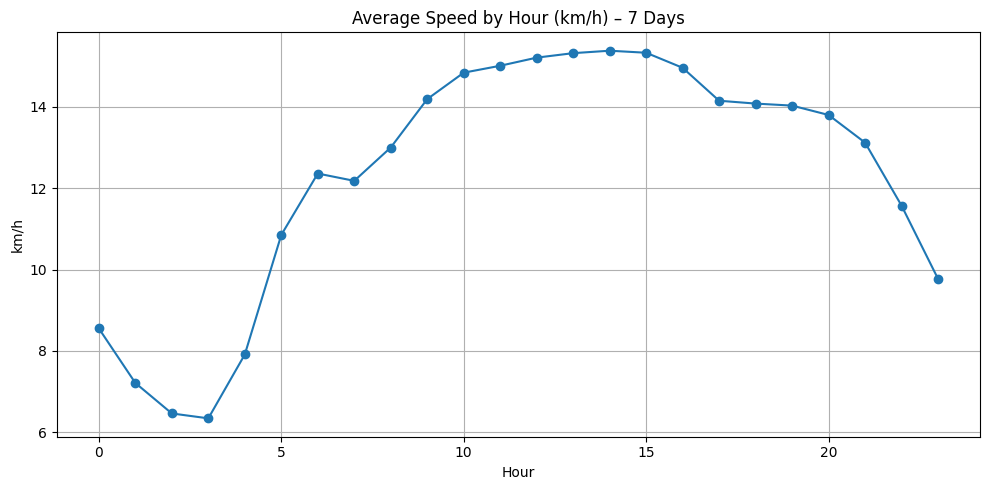

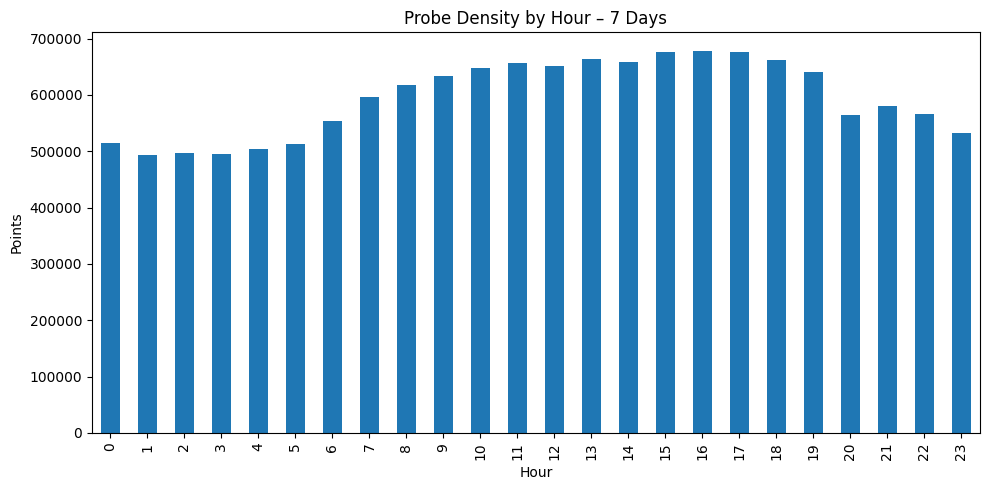

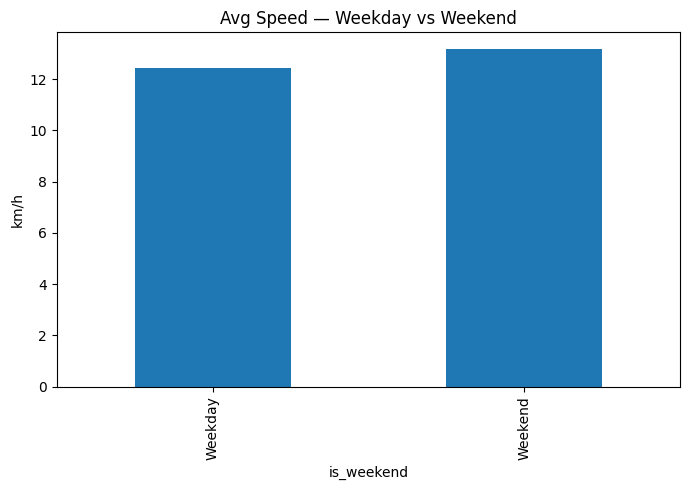

In [31]:
# Visualizations 
plt.figure(figsize=(10,5))
speed_by_hour.plot(marker='o', title='Average Speed by Hour (km/h) – 7 Days')
plt.xlabel('Hour'); plt.ylabel('km/h'); plt.grid(True); plt.tight_layout()
plt.savefig(EXP/'images_avg_speed_by_hour.png', dpi=140)

plt.figure(figsize=(10,5))
points_by_hour.plot(kind='bar', title='Probe Density by Hour – 7 Days')
plt.xlabel('Hour'); plt.ylabel('Points'); plt.tight_layout()
plt.savefig(EXP/'images_points_by_hour.png', dpi=140)

plt.figure(figsize=(7,5))
wk_speed.plot(kind='bar', title='Avg Speed — Weekday vs Weekend')
plt.ylabel('km/h'); plt.tight_layout()
plt.savefig(EXP/'images_speed_weekday_weekend.png', dpi=140)

print('Saved charts to /exports ✅')


In [32]:
hourly.to_csv(EXP/'probe_7days_hourly.csv', index=False)
speed_by_hour.to_csv(EXP/'speed_by_hour.csv')
points_by_hour.to_csv(EXP/'points_by_hour.csv')
wk_speed.to_csv(EXP/'weekend_vs_weekday_speed.csv')
wk_points.to_csv(EXP/'weekend_vs_weekday_points.csv')
print('Saved CSVs to /exports ✅')


Saved CSVs to /exports ✅


In [33]:
delta_wk = float(wk_speed['Weekend'] - wk_speed['Weekday'])
summary = f"""
**Bangkok 7-Day Probe Analysis — Highlights**

• Slowest hour: H={peak_slow_hour}, avg ≈ {min_speed:.2f} km/h
• Fastest hour: H={peak_fast_hour}, avg ≈ {max_speed:.2f} km/h
• Busiest hour by density: H={busiest_hour}, ≈ {busiest_points:,} probe points
• Weekend vs Weekday: {wk_speed['Weekend']:.2f} vs {wk_speed['Weekday']:.2f} km/h (Δ ≈ {delta_wk:.2f} km/h)

Data: 7 daily Longdo probe files (June 1–7, 2024). Pipeline: Pandas ETL → hourly aggregation → charts & CSV exports.
"""
print(summary)



**Bangkok 7-Day Probe Analysis — Highlights**

• Slowest hour: H=3, avg ≈ 6.34 km/h
• Fastest hour: H=14, avg ≈ 15.38 km/h
• Busiest hour by density: H=16, ≈ 677,165 probe points
• Weekend vs Weekday: 13.17 vs 12.42 km/h (Δ ≈ 0.75 km/h)

Data: 7 daily Longdo probe files (June 1–7, 2024). Pipeline: Pandas ETL → hourly aggregation → charts & CSV exports.



In [34]:
pip install sqlite3-binary


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sqlite3-binary (from versions: none)
ERROR: No matching distribution found for sqlite3-binary

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import sqlite3

conn = sqlite3.connect("traffic.db")

hourly.to_sql("traffic_hourly", conn, if_exists="replace", index=False)

conn.commit()
conn.close()

print("✅ SQLite database created and data loaded!")


✅ SQLite database created and data loaded!


In [36]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("traffic.db")

def sql(query):
    return pd.read_sql_query(query, conn)


In [37]:
sql("""
SELECT hour, AVG(avg_speed) AS avg_speed
FROM traffic_hourly
GROUP BY hour
ORDER BY avg_speed ASC
LIMIT 5;
""")


,hour,avg_speed
0,3,6.341522
1,2,6.462748
2,1,7.212052
3,4,7.907262
4,0,8.554900


In [38]:
sql("""
SELECT hour, SUM(points) AS total_points
FROM traffic_hourly
GROUP BY hour
ORDER BY total_points DESC
LIMIT 5;
""")


,hour,total_points
0,16,677165
1,15,676111
2,17,675637
3,13,664239
4,18,661866


In [39]:
sql("""
SELECT 
    CASE WHEN strftime('%w', date) IN ('0','6') THEN 'Weekend' ELSE 'Weekday' END AS day_type,
    AVG(avg_speed) AS avg_speed,
    SUM(points) AS total_points
FROM traffic_hourly
GROUP BY day_type;
""")


,day_type,avg_speed,total_points
0,Weekday,12.079818,10220362
1,Weekend,12.912448,4051659


In [40]:
sql("""
SELECT date, AVG(avg_speed) AS avg_speed
FROM traffic_hourly
GROUP BY date
ORDER BY date;
""")


,date,avg_speed
0,2024-06-01 00:00:00,13.019651
1,2024-06-02 00:00:00,12.805245
2,2024-06-03 00:00:00,12.348629
3,2024-06-04 00:00:00,11.783535
4,2024-06-05 00:00:00,11.946931
5,2024-06-06 00:00:00,12.078183
6,2024-06-07 00:00:00,12.241811


In [41]:
result = sql("""
SELECT hour, AVG(avg_speed) AS avg_speed
FROM traffic_hourly
GROUP BY hour
ORDER BY hour;
""")

result.to_csv("exports/sql_hourly_avg_speed.csv", index=False)


In [42]:
delta_wk = float(wk_speed['Weekend'] - wk_speed['Weekday'])
print({
    "slowest_hour": int(peak_slow_hour),
    "slowest_speed_kmh": round(min_speed, 2),
    "fastest_hour": int(peak_fast_hour),
    "fastest_speed_kmh": round(max_speed, 2),
    "busiest_hour": int(busiest_hour),
    "busiest_points": int(busiest_points),
    "weekday_speed": float(wk_speed['Weekday']),
    "weekend_speed": float(wk_speed['Weekend']),
    "delta_weekend_minus_weekday": round(delta_wk, 2)
})


{'slowest_hour': 3, 'slowest_speed_kmh': 6.34, 'fastest_hour': 14, 'fastest_speed_kmh': 15.38, 'busiest_hour': 16, 'busiest_points': 677165, 'weekday_speed': 12.42, 'weekend_speed': 13.17, 'delta_weekend_minus_weekday': 0.75}


In [43]:
from pathlib import Path
EXP = Path("exports"); EXP.mkdir(exist_ok=True)


n = 150_000  
pts = (raw[['lat','lon','speed','date','hour','is_weekend']]
       .dropna()
       .sample(min(n, len(raw)), random_state=42))


pts['speed'] = pts['speed'].clip(0, 120)


pts.to_csv(EXP/'points_sample.csv', index=False)
print("Saved:", EXP/'points_sample.csv', "rows:", len(pts))


Saved: exports\points_sample.csv rows: 150000


##
Random info about project

In [1]:
import pandas as pd
import glob
from pathlib import Path

DATA = Path("data")

files = sorted(glob.glob(str(DATA / "2024060*.csv.out")))
print("Files found:", len(files))

total_rows = 0
rows_per_file = {}

for f in files:
    df = pd.read_csv(f, header=None)
    n = len(df)
    rows_per_file[f] = n
    total_rows += n

print("\nRows per file:")
for f, n in rows_per_file.items():
    print(f"{Path(f).name}: {n:,}")

print("\nTOTAL rows across all 7 days:", f"{total_rows:,}")


Files found: 7

Rows per file:
20240601.csv.out: 2,059,148
20240602.csv.out: 1,992,412
20240603.csv.out: 1,984,483
20240604.csv.out: 1,982,698
20240605.csv.out: 2,075,853
20240606.csv.out: 2,078,579
20240607.csv.out: 2,104,876

TOTAL rows across all 7 days: 14,278,049
